In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from types import SimpleNamespace

# Import functions from codebase modules
from arma import generate_arma_batch
from loss import contrastive_latent_loss
from network import *


In [2]:
# Data generation wrapper for backward compatibility
def generate_random_batch(batch_size=16, T_raw=4096, C=4, mean=0.0, std=1.0, seed=None):
    """Generate multivariate random walks using ARMA processes."""
    X, _ = generate_arma_batch(batch_size=batch_size, T_raw=T_raw, C=C, mean=mean, std=std, seed=seed, dimension=4)
    return X


In [3]:
# Generate sample data and initialize model
x = generate_random_batch(batch_size=32, T_raw=4096)
print(f"Data shape: {x.shape}")

model = SimpleModel(C=4, H=64, W=32)
print(f"Model initialized: {model.__class__.__name__}")

Data shape: torch.Size([32, 4096, 4])
Model initialized: SimpleModel


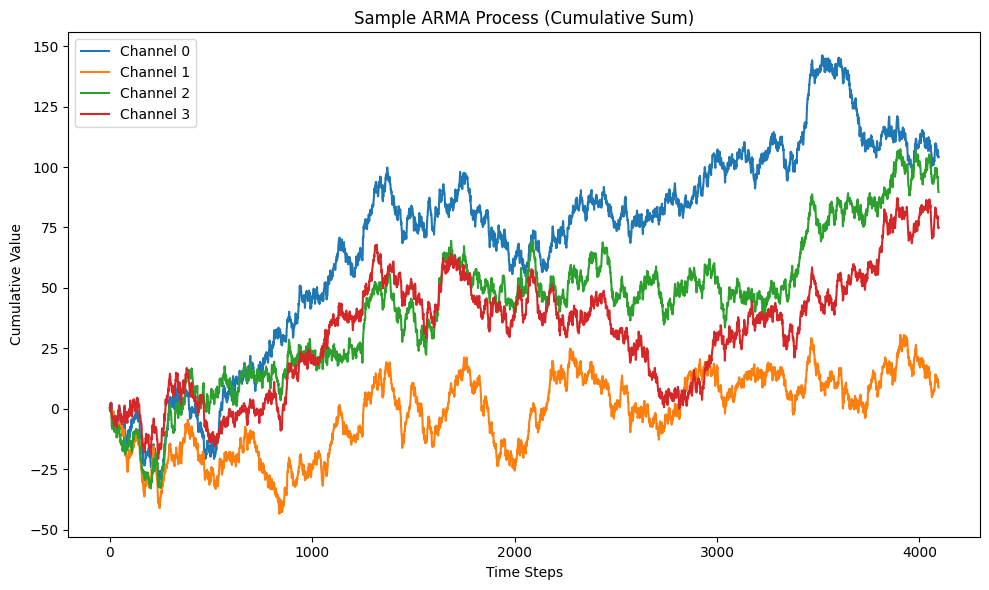

In [4]:
# Visualize sample data
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(x[0, :, :], axis=0))
plt.title('Sample ARMA Process (Cumulative Sum)')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Value')
plt.legend([f'Channel {i}' for i in range(x.shape[2])])
plt.tight_layout()
plt.show()

In [5]:
# Test model forward pass
h_hat, h = model(x)
print(f"Forecasted latent shape: {h_hat.shape}")
print(f"Original latent shape: {h.shape}")

Forecasted latent shape: torch.Size([32, 128, 4, 64])
Original latent shape: torch.Size([32, 128, 4, 64])


In [6]:
# Test loss computation
spec = SimpleNamespace(
    train_configuration={
        'contrastive_divergence_temperature': 0.05,
        'contrastive_latent_noise': None,
        'loss_shape': 'cosine_similarity'
    }
)

loss = contrastive_latent_loss(
    predicted_position=[h, h_hat],
    validation=False,
    spec=spec,
    get_history=False
)

print(f"Contrastive latent loss: {loss.item():.4f}")



Contrastive latent loss: 21.1860


In [ ]:
def create_training_state():
    """Create a new training state dictionary."""
    return {
        'steps': [],
        'train_metrics': {'ff': [], 'fp': [], 'tp': [], 'cross_batch': []},
        'val_metrics': {'ff': [], 'fp': [], 'tp': [], 'cross_batch': []},
        'current_step': 0,
        'model': None,
        'optimizer': None,
        'x_val': None,
        'spec': None,
        'cld': None
    }

def setup_training(model, C, H, W, batch_size, device, lr=1e-4):
    """Initialize training setup with model, optimizer, and validation data."""
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    
    # Fixed validation set
    x_val = generate_random_batch(batch_size, T_raw=4096, C=C, seed=0).to(device)
    Bv, Tr, _ = x_val.shape
    T = Tr // W
    xt_val = x_val.view(Bv, T, W, C).permute(0,1,3,2)  # [Bv, T, C, W]
    
    # Training configuration
    spec = SimpleNamespace(train_configuration={
        'contrastive_divergence_temperature': 0.07,
        'contrastive_latent_noise': None,
        'loss_shape': 'cosine_similarity_batch_no_time_neg',  # No cross-time negatives (for ARMA)
        'contrastive_latent_delay': 0
    })
    cld = spec.train_configuration['contrastive_latent_delay'] + 1
    
    return model, optimizer, xt_val, spec, cld

def compute_metrics(f_lat, o_lat, cld):
    """Compute forecast-future, forecast-past, future-past, and cross-batch cosine similarities."""
    fn = F.normalize(f_lat, p=2, dim=-1)
    on = F.normalize(o_lat, p=2, dim=-1)
    hyh = fn[:, :-cld, :, :]
    hyn = on[:,  cld:, :, :]
    hxn = on[:, :-cld, :, :]
    
    ff = (hyh * hyn).sum(-1).mean().item()
    fp = (hyh * hxn).sum(-1).mean().item()
    tp = (hyn * hxn).sum(-1).mean().item()
    
    # Cross-batch similarity: compare hy from batch i with hy_hat from batch j (i != j)
    B, T, C, H = hyh.shape
    hyh_exp = hyh.unsqueeze(0)  # [1, B, T, C, H]
    hyn_exp = hyn.unsqueeze(1)  # [B, 1, T, C, H]
    
    # Compute similarities across batch dimension: [B, B, T, C]
    sims_cross_batch = (hyh_exp * hyn_exp).sum(-1)  # [B, B, T, C]
    
    # Create mask to exclude same batch element (diagonal)
    mask_batch = ~torch.eye(B, dtype=torch.bool, device=sims_cross_batch.device)
    mask_batch = mask_batch.view(B, B, 1, 1)
    
    # Mask and compute mean across batches
    sims_masked = sims_cross_batch.masked_fill(~mask_batch, 0)
    cross_batch = sims_masked.mean().item()
    
    return ff, fp, tp, cross_batch

def train_step(model, optimizer, loss_fn, C, H, W, batch_size, device, spec):
    """Execute a single training step."""
    model.train()
    optimizer.zero_grad()
    
    # Generate training batch
    x_train = generate_random_batch(batch_size, T_raw=4096, C=C).to(device)
    Bt, _, _ = x_train.shape
    T = x_train.shape[1] // W
    xt = x_train.view(Bt, T, W, C).permute(0,1,3,2)  # [Bt, T, C, W]
    
    # Forward pass
    f_flat, o_flat = model.transformer(xt)
    # f_flat and o_flat have shape [Bt*C, T, H]
    f_lat = f_flat.reshape(Bt, C, T, H).permute(0,2,1,3)  # [Bt, T, C, H]
    o_lat = o_flat.reshape(Bt, C, T, H).permute(0,2,1,3)  # [Bt, T, C, H]
    
    # Compute loss and backprop
    loss = loss_fn((f_lat, o_lat), validation=False, spec=spec)
    loss.backward()
    optimizer.step()
    
    return loss.item(), f_lat, o_lat

def validation_step(model, x_val, loss_fn, spec, cld):
    """Execute validation step."""
    model.eval()
    with torch.no_grad():
        fv_flat, ov_flat = model.transformer(x_val)
        Bv, T, C, W = x_val.shape  # x_val has shape [Bv, T, C, W]
        H = model.H  # Get H from model
        
        # Reshape the flat outputs correctly
        # fv_flat and ov_flat have shape [Bv*C, T, H]
        fv = fv_flat.reshape(Bv, C, T, H).permute(0,2,1,3)  # [Bv, T, C, H]
        ov = ov_flat.reshape(Bv, C, T, H).permute(0,2,1,3)  # [Bv, T, C, H]
        
        return compute_metrics(fv, ov, cld)

def plot_training_curves(training_state):
    """Plot training metrics curves."""
    plt.figure(figsize=(8, 4))
    
    steps = range(1, len(training_state['train_metrics']['ff'])+1)
    plt.plot(steps, training_state['train_metrics']['ff'], label='Train Forecast vs Future')
    plt.plot(steps, training_state['train_metrics']['fp'], label='Train Forecast vs Past')
    plt.plot(steps, training_state['train_metrics']['tp'], label='Train Future vs Past')
    plt.plot(steps, training_state['train_metrics']['cross_batch'], label='Cross-Batch Similarity', color='red')
    plt.xlabel('Step')
    plt.ylabel('Mean Cosine Similarity')
    plt.title('Training Metrics')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_validation_curves(training_state):
    """Plot validation metrics curves."""
    plt.figure(figsize=(8, 4))
    
    plt.plot(training_state['steps'], training_state['val_metrics']['ff'], label='Val Forecast vs Future')
    plt.plot(training_state['steps'], training_state['val_metrics']['fp'], label='Val Forecast vs Past')
    plt.plot(training_state['steps'], training_state['val_metrics']['tp'], label='Val Future vs Past')
    plt.plot(training_state['steps'], training_state['val_metrics']['cross_batch'], label='Cross-Batch Similarity', color='red')
    plt.xlabel('Step')
    plt.ylabel('Mean Cosine Similarity')
    plt.title('Validation Metrics')
    plt.legend()
    plt.tight_layout()
    plt.show()

def train_model(model, loss_fn, C, H, W, total_steps=500, batch_size=8, 
                lr=1e-4, device='cpu', val_every=50, training_state=None):
    """
    Train model with re-entry capability.
    
    Args:
        training_state: Dictionary containing training state. If None, creates a new one.
    """
    # Create or use provided training state
    if training_state is None:
        training_state = create_training_state()
    
    # Setup training if not already done
    if training_state['model'] is None:
        model, optimizer, x_val, spec, cld = setup_training(model, C, H, W, batch_size, device, lr)
        training_state.update({
            'model': model,
            'optimizer': optimizer,
            'x_val': x_val,
            'spec': spec,
            'cld': cld,
            'current_step': 0
        })
    else:
        model = training_state['model']
        optimizer = training_state['optimizer']
        x_val = training_state['x_val']
        spec = training_state['spec']
        cld = training_state['cld']
    
    current_step = training_state['current_step']
    
    # Training loop
    for step in range(current_step + 1, total_steps + 1):
        # Training step
        loss_val, f_lat, o_lat = train_step(model, optimizer, loss_fn, C, H, W, batch_size, device, spec)
        
        # Compute training metrics
        train_ff, train_fp, train_tp, train_cross_batch = compute_metrics(f_lat, o_lat, cld)
        training_state['train_metrics']['ff'].append(train_ff)
        training_state['train_metrics']['fp'].append(train_fp)
        training_state['train_metrics']['tp'].append(train_tp)
        training_state['train_metrics']['cross_batch'].append(train_cross_batch)
        
        # Validation step
        if step % val_every == 0 or step == total_steps:
            val_ff, val_fp, val_tp, val_cross_batch = validation_step(model, x_val, loss_fn, spec, cld)
            training_state['val_metrics']['ff'].append(val_ff)
            training_state['val_metrics']['fp'].append(val_fp)
            training_state['val_metrics']['tp'].append(val_tp)
            training_state['val_metrics']['cross_batch'].append(val_cross_batch)
            training_state['steps'].append(step)
            
            print(f"[Step {step}] train loss {loss_val:.4f} | "
                  f"train FF={train_ff:.4f}, FP={train_fp:.4f}, TP={train_tp:.4f}, CrossBatch={train_cross_batch:.4f} || "
                  f"val   FF={val_ff:.4f}, FP={val_fp:.4f}, TP={val_tp:.4f}, CrossBatch={val_cross_batch:.4f}")
            
            # Plot curves
            try:
                plot_training_curves(training_state)
                plot_validation_curves(training_state)
            except Exception as e:
                print(f"Plotting error: {e}")
        else:
            print(f"[Step {step}] train loss {loss_val:.4f}")
        
        # Update current step
        training_state['current_step'] = step
    
    # Final plots
    plot_training_curves(training_state)
    plot_validation_curves(training_state)
    
    return model, training_state

In [ ]:
# Initialize model
model = SimpleModel(C=4, H=1024, W=32, num_layers=12)
training_state = create_training_state()

In [ ]:
# Start training
trained_model, training_state = train_model(
    model,
    loss_fn=contrastive_latent_loss,
    C=4, H=1024, W=32,
    total_steps=2_000_000,
    batch_size=16,
    lr=1e-4,
    device='cuda',
    val_every=500,
    training_state=training_state,
)

In [ ]:
# Save the trained model
torch.save(trained_model.state_dict(), 'trained_simple_model_H1024.pth')
print("Model saved to 'trained_simple_model_H1024.pth'")

In [21]:
3

3

In [13]:
# Example: Resume training from where you left off (re-entry capability)
# This allows you to interrupt training and continue from where you left off

print(f"Current step: {training_state['current_step']}")
print(f"Training metrics length: {len(training_state['train_metrics']['ff'])}")
print(f"Validation steps: {training_state['steps']}")

# To resume training from where you left off:
# resumed_model, updated_state = train_model(
#     model,
#     loss_fn=contrastive_latent_loss,
#     C=4, H=64, W=32,
#     total_steps=1000,  # Continue to step 1000
#     batch_size=32,
#     lr=1e-4,
#     device='cuda',
#     val_every=500,
#     training_state=training_state  # Pass the existing state
# )

# To start fresh training with a new state:
# new_model = SimpleModel(C=4, H=64, W=32)
# fresh_model, new_state = train_model(
#     new_model,
#     loss_fn=contrastive_latent_loss,
#     C=4, H=64, W=32,
#     total_steps=1000,
#     batch_size=32,
#     lr=1e-4,
#     device='cuda',
#     val_every=500,
#     training_state=None  # Creates a new state
# )


Current step: 50000
Training metrics length: 50000
Validation steps: [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500, 40000, 40500, 41000, 41500, 42000, 42500, 43000, 43500, 44000, 44500, 45000, 45500, 46000, 46500, 47000, 47500, 48000, 48500, 49000, 49500, 50000]
